# Environment settings
24.08.13

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [ ]:
import sys, warnings; warnings.simplefilter('ignore')

import scvi
scvi.settings.seed=42
from scvi.data import AnnDataManager

import scanpy as sc
import anndata

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors, rcParams
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import pandas as pd
import itertools
import gc

import numpy.random as random
import scipy.sparse
from scipy.sparse import csr_matrix, issparse

from preprocess_functions import *
from integration_functions import *
import genes
import vae_training_functions
import utils as ut

In [ ]:
import torch
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print()
from subprocess import call
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print()
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number of CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
    print('__CUDA Current Device:', torch.cuda.current_device())

In [ ]:
from scvi import REGISTRY_KEYS
from scvi.data.fields import (
    LayerField,
    CategoricalObsField,
    NumericalObsField,
    CategoricalJointObsField,
    NumericalJointObsField,
)

import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)

import anndata2ri
anndata2ri.activate()

In [ ]:
%load_ext rpy2.ipython
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(figsize=(4, 4), dpi=80, facecolor='white')

In [ ]:
print("Last run with scvi-tools version:", scvi.__version__)

# 01. Run scVI 2024.08.06

## 01) Merged Data Creation

In [ ]:
data_dir = "/mnt/gmi-l1/_90.User_Data/sylash92/0.SCAID_Analysis/05.Preprocessing/Merged_Objects/"

In [ ]:
import os

def find_h5ad(directory):
    h5ad_file_path_list = []
    for root, _, files in os.walk(directory):
        for file in files:
            if "celltypist" in file and file.endswith(".h5ad"):
                h5ad_file_path_list.append(os.path.join(root, file))
    return h5ad_file_path_list

In [ ]:
h5ad_file_path_list = sorted(find_h5ad(data_dir))

In [ ]:
h5ad_file_path_list

In [ ]:
### list of file names only
h5ad_file_names = [os.path.basename(path) for path in h5ad_file_path_list]

In [ ]:
sample_ids = [file.split('.')[1] for file in h5ad_file_names]

In [ ]:
sample_ids

In [ ]:
### Read h5ad files and create a dictionary of AnnData
adata_dict={}
for SampleID, H5Path in zip(sample_ids, h5ad_file_path_list):
    adata_dict[SampleID] = sc.read_h5ad(H5Path)
    adata_dict[SampleID].var_names_make_unique()
    adata_dict[SampleID].X = adata_dict[SampleID].layers["counts"].copy()

In [ ]:
## Merge adata_list as one adata
merged_scaid = merge_matrix(adata_dict)
merged_scaid.layers["counts"]=merged_scaid.X.copy()

In [ ]:
merged_scaid.obs = merged_scaid.obs.drop(columns=['res.1.2', 'res.1.4', 'res.1.6', 'res.1.8', 'res.2.0', 'res.2.2', 'res.2.4', 'res.2.6', 'res.2.8', 'res.3.0', 
                                                  'Library_ID', 'souporcell_status', 'souporcell_assignment', 'num_features', 'feature_call', 'num_umis','csp_assignment'])

In [ ]:
merged_scaid.obs=merged_scaid.obs.rename(columns={"name":"disease"})

In [ ]:
disease_mapping={"AA":"Alopecia Areata",
                 "AD":"Atopic Dermatitis",
                 "AS":"Asthma",
                 "HD":"Cardiovascular Diseases",
                 "IBD":"Inflammatory Bowel Disease",
                 "ILD":"Interstitial Lung Disease",
                 "KID":"Chronic Kidney Disease",
                 "LVR":"MAFLD/MASH",
                 "MS":"Multiple Sclerosis",
                 "NP":"Nasal Polyp",
                 "PIBD":"Pediatric IBD",
                 "PSO":"Psoriasis",
                 "RAAS":"Rheumatoid Arthritis"}

In [ ]:
# Apply mappings to DataFrame
merged_scaid.obs['disease'] = merged_scaid.obs['disease'].map(disease_mapping)

In [ ]:
merged_scaid.X

In [ ]:
merged_scaid.layers['counts']

In [ ]:
few_selected_HKG_HEG=["GAPDH","ACTB","RPL13A","RPLP0","B2M","PPIA","MALAT1","FTL","FTH1"]
pd.DataFrame.sparse.from_spmatrix(merged_scaid.layers["counts"], index = merged_scaid.obs_names, columns = merged_scaid.var.index).loc[:,few_selected_HKG_HEG]#.head(5)

In [ ]:
few_selected_HKG_HEG=["GAPDH","ACTB","RPL13A","RPLP0","B2M","PPIA","MALAT1","FTL","FTH1"]
pd.DataFrame.sparse.from_spmatrix(merged_scaid.X, index = merged_scaid.obs_names, columns = merged_scaid.var.index).loc[:,few_selected_HKG_HEG]#.head(5)

In [ ]:
countsum=merged_scaid.to_df().sum()

In [ ]:
# Check if all sum results are integers (including float values like 64.0)
are_integers = (countsum % 1 == 0).all()

# Display the results
print("Sum of Counts per Gene:")
print(countsum)
print("\nAre all sums integers?", are_integers)

In [ ]:
## Save Anndata
merged_scaid.write_h5ad("SCAID.All.merged.h5ad".format(d=data_dir))

## 02) HVG Selection

In [ ]:
data_dir = "/mnt/gmi-l1/_90.User_Data/sylash92/0.SCAID_Analysis/06.Integration/"

In [ ]:
adata_train=sc.read_h5ad("{d}SCAID.All.merged.h5ad".format(d=data_dir))

In [ ]:
few_selected_HKG_HEG=["GAPDH","ACTB","RPL13A","RPLP0","B2M","PPIA","MALAT1","FTL","FTH1"]
pd.DataFrame.sparse.from_spmatrix(adata_train.layers["counts"], index = adata_train.obs_names, columns = adata_train.var.index).loc[:,few_selected_HKG_HEG]#.head(5)

In [ ]:
adata_train.var_names_make_unique()

In [ ]:
%%time
### Filter Genes before HVG Selection
### if min_counts is set, must check if adata.X is "counts" layer.
### if min_cells is set, it does not matter.
sc.pp.filter_genes(adata_train, min_cells=10)

In [ ]:
adata_train

In [ ]:
adata_train.X = adata_train.layers['counts'].copy()
sc.pp.normalize_total(adata_train, target_sum=1e4)
sc.pp.log1p(adata_train)

In [ ]:
def hvg_batch(
    adata,
    batch_key=None,
    target_genes=2000,
    flavor="cell_ranger",
    n_bins=20,
    adataOut=False,
):
    """Batch-aware highly variable gene selection

    Method to select HVGs based on mean dispersions of genes that are highly
    variable genes in all batches. Using a the top target_genes per batch by
    average normalize dispersion. If target genes still hasn't been reached,
    then HVGs in all but one batches are used to fill up. This is continued
    until HVGs in a single batch are considered.

    :param adata: ``anndata`` object
    :param batch: ``adata.obs`` column
    :param target_genes: maximum number of genes (intersection reduces the number of genes)
    :param flavor: parameter for ``scanpy.pp.highly_variable_genes``
    :param n_bins: parameter for ``scanpy.pp.highly_variable_genes``
    :param adataOut: whether to return an ``anndata`` object or a list of highly variable genes
    """

    adata_hvg = adata if adataOut else adata.copy()

    n_batches = len(adata_hvg.obs[batch_key].cat.categories)

    # Calculate double target genes per dataset
    sc.pp.highly_variable_genes(
        adata_hvg,
        flavor=flavor,
        n_top_genes=target_genes,
        n_bins=n_bins,
        batch_key=batch_key,
    )

    nbatch1_dispersions = adata_hvg.var["dispersions_norm"][
        adata_hvg.var.highly_variable_nbatches
        > len(adata_hvg.obs[batch_key].cat.categories) - 1
    ]

    nbatch1_dispersions.sort_values(ascending=False, inplace=True)

    if len(nbatch1_dispersions) > target_genes:
        hvg = nbatch1_dispersions.index[:target_genes]

    else:
        enough = False
        print(f"Using {len(nbatch1_dispersions)} HVGs from full intersect set")
        hvg = nbatch1_dispersions.index[:]
        not_n_batches = 1

        while not enough:
            target_genes_diff = target_genes - len(hvg)

            tmp_dispersions = adata_hvg.var["dispersions_norm"][
                adata_hvg.var.highly_variable_nbatches == (n_batches - not_n_batches)
            ]

            if len(tmp_dispersions) < target_genes_diff:
                print(
                    f"Using {len(tmp_dispersions)} HVGs from n_batch-{not_n_batches} set"
                )
                hvg = hvg.append(tmp_dispersions.index)
                not_n_batches += 1

            else:
                print(
                    f"Using {target_genes_diff} HVGs from n_batch-{not_n_batches} set"
                )
                tmp_dispersions.sort_values(ascending=False, inplace=True)
                hvg = hvg.append(tmp_dispersions.index[:target_genes_diff])
                enough = True

    print(f"Using {len(hvg)} HVGs")

    if not adataOut:
        del adata_hvg
        return hvg.tolist()
    else:
        return adata_hvg[:, hvg].copy()

### HVG with Variance Seurat V3 Flavor

In [ ]:
# function to calculate variances on *sparse* matrix
def vars(a, axis=None):
    """ Variance of sparse matrix a
    var = mean(a**2) - mean(a)**2
    """
    a_squared = a.copy()
    a_squared.data **= 2
    return a_squared.mean(axis) - np.square(a.mean(axis))

In [ ]:
means = np.mean(adata_train.X, axis=0)
variances = vars(adata_train.X, axis=0)
dispersions = variances / means

gene_names = np.matrix(adata_train.var_names.to_numpy())[0]
min_mean = 0.03

In [ ]:
plt.rcParams["figure.figsize"] = [15,15]
plt.scatter(
    np.log1p(means).tolist()[0], np.log(dispersions).tolist()[0], s=2
)
plt.vlines(x=np.log1p(min_mean), ymin=0, ymax=2, color='red')
plt.xlabel("log1p(mean)")
plt.ylabel("log(dispersion)")
plt.title("DISPERSION VERSUS MEAN")

# Convert means to a NumPy array
means_array = np.array(means)

# Filter data where log1p(mean) is larger than 1 and log(dispersion) is larger than 0
filter_condition = (np.log1p(means_array) > 1) & (np.log(dispersions) < 0)
filtered_indices = np.where(filter_condition)[1]
filtered_means = means_array[:, filtered_indices]
filtered_dispersions = dispersions[:, filtered_indices]
filtered_gene_names = gene_names[:, filtered_indices]

# Annotate points with gene names
for i, gene_name in enumerate(filtered_gene_names.tolist()[0]):
    plt.text(np.log1p(filtered_means).tolist()[0][i], np.log(filtered_dispersions).tolist()[0][i], gene_name, fontsize=8)

plt.show()

### Add Filter for dispersion and min expression(optional)

### Select highly variable genes

In [ ]:
%%time
### HVG ###
### for seurat or cell_ranger / "CP10K"
### for seurat_v3 or seurat_v3_paper / "counts"

n_top_genes = 10000
hvg_flavor  = "seurat_v3_paper"
hvg_layer   = "counts"
sc.settings.verbosity = 4

sc.pp.highly_variable_genes(
    adata_train,
    n_top_genes = n_top_genes,
    layer  = hvg_layer,
    flavor = hvg_flavor,
    batch_key="Sample_ID",
    n_bins = 20,
    span = 1.0
)

In [ ]:
plt.rcParams["figure.figsize"] = [10,10]

boolean_to_color = {
    True: "crimson",
    False: "steelblue",
}  # make a dictionary that translates the boolean to colors
hvg_colors = adata_train.var.highly_variable.map(boolean_to_color)  # 'convert' the boolean
# now plot
plt.scatter(
    np.log1p(means).tolist()[0], np.log(dispersions).tolist()[0], s=1, c=hvg_colors
)
plt.xlabel("log1p(mean)")
plt.ylabel("log(dispersion)")
plt.title("DISPERSION VERSUS MEAN")
plt.show()

In [ ]:
## Subset Anndata
adata_train = adata_train[:, adata_train.var["highly_variable"]].copy()

### Check for any missing batch annotation

In [ ]:
empty_or_missing = adata_train[adata_train.obs['Sample_ID'].isna()]

In [ ]:
empty_or_missing.obs.Library.value_counts().sort_index()

In [ ]:
adata_train = adata_train[~adata_train.obs.Sample_ID.isna()].copy()

In [ ]:
adata_train

In [ ]:
## Save Anndata
adata_train.write_h5ad("{d}SCAID.All.merged.scVI_train.hvg{n}.h5ad".format(d=data_dir,n=n_top_genes))

## 03) Set Up Anndata

In [ ]:
data_dir = "/mnt/gmi-l1/_90.User_Data/sylash92/0.SCAID_Analysis/06.Integration/"
n_top_genes=10000

In [ ]:
adata_train=sc.read_h5ad("{d}SCAID.All.merged.scVI_train.hvg{n}.h5ad".format(d=data_dir, n=n_top_genes))

In [ ]:
# Assuming 'adata' is your AnnData object
adata_train.obs['Suspension_Type'].fillna('Cell', inplace=True)

In [ ]:
import gc
gc.collect()

In [ ]:
scvi.model.SCVI.setup_anndata(adata_train,
                              batch_key="Sample_ID",
                              categorical_covariate_keys=['Suspension_Type'],
                              continuous_covariate_keys=['pct_counts_mt','background_fraction'],
                              layer='counts')

In [ ]:
print(f"adata UUID (assigned by setup_anndata): {adata_train.uns['_scvi_uuid']}")

In [ ]:
scvi.model.SCVI._setup_adata_manager_store[adata_train.uns['_scvi_uuid']]

## 04) Set up scVI params

In [ ]:
### use_size_factor_key: Default is False. Takes priority over use_observed_lib_size
### use_observed_lib_size: Default is True
### latent_distribution: Default is 'normal' | 'ln' for logistic normal with normal params N(0,1)

params = dict(
    dropout_rate=0.1,
    n_layers=2,
    n_latent=50,
    n_hidden=128,
    gene_likelihood="zinb",
    dispersion='gene',
    #encode_covariates=True,
    #deeply_inject_covariates=True,
    #use_size_factor_key=True,
    #use_observed_lib_size=False,
    #latent_distribution='ln'
)

In [ ]:
vae = scvi.model.SCVI(adata_train, **params)

## 05) Run scVI train

In [ ]:
from torch.utils.data import DataLoader, Dataset
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.callbacks import LearningRateFinder
from tqdm import tqdm
from multiprocessing import Lock
tqdm.set_lock(Lock())  # manually set internal lock
tqdm.write("test")

In [ ]:
torch.set_float32_matmul_precision('high')

In [20]:
vae.train(early_stopping=True,
          plan_kwargs={"reduce_lr_on_plateau":True, "optimizer":"AdamW", "lr":1e-4},
          accelerator='gpu',
          devices=[1],
          train_size=0.9,
          max_epochs=300,
          early_stopping_patience=100,
          batch_size=20000)

Epoch 300/300: 100%|█| 300/300 [7:17:15<00:00, 87.19s/it, v_num=1, train_loss_st

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|█| 300/300 [7:17:15<00:00, 87.45s/it, v_num=1, train_loss_st


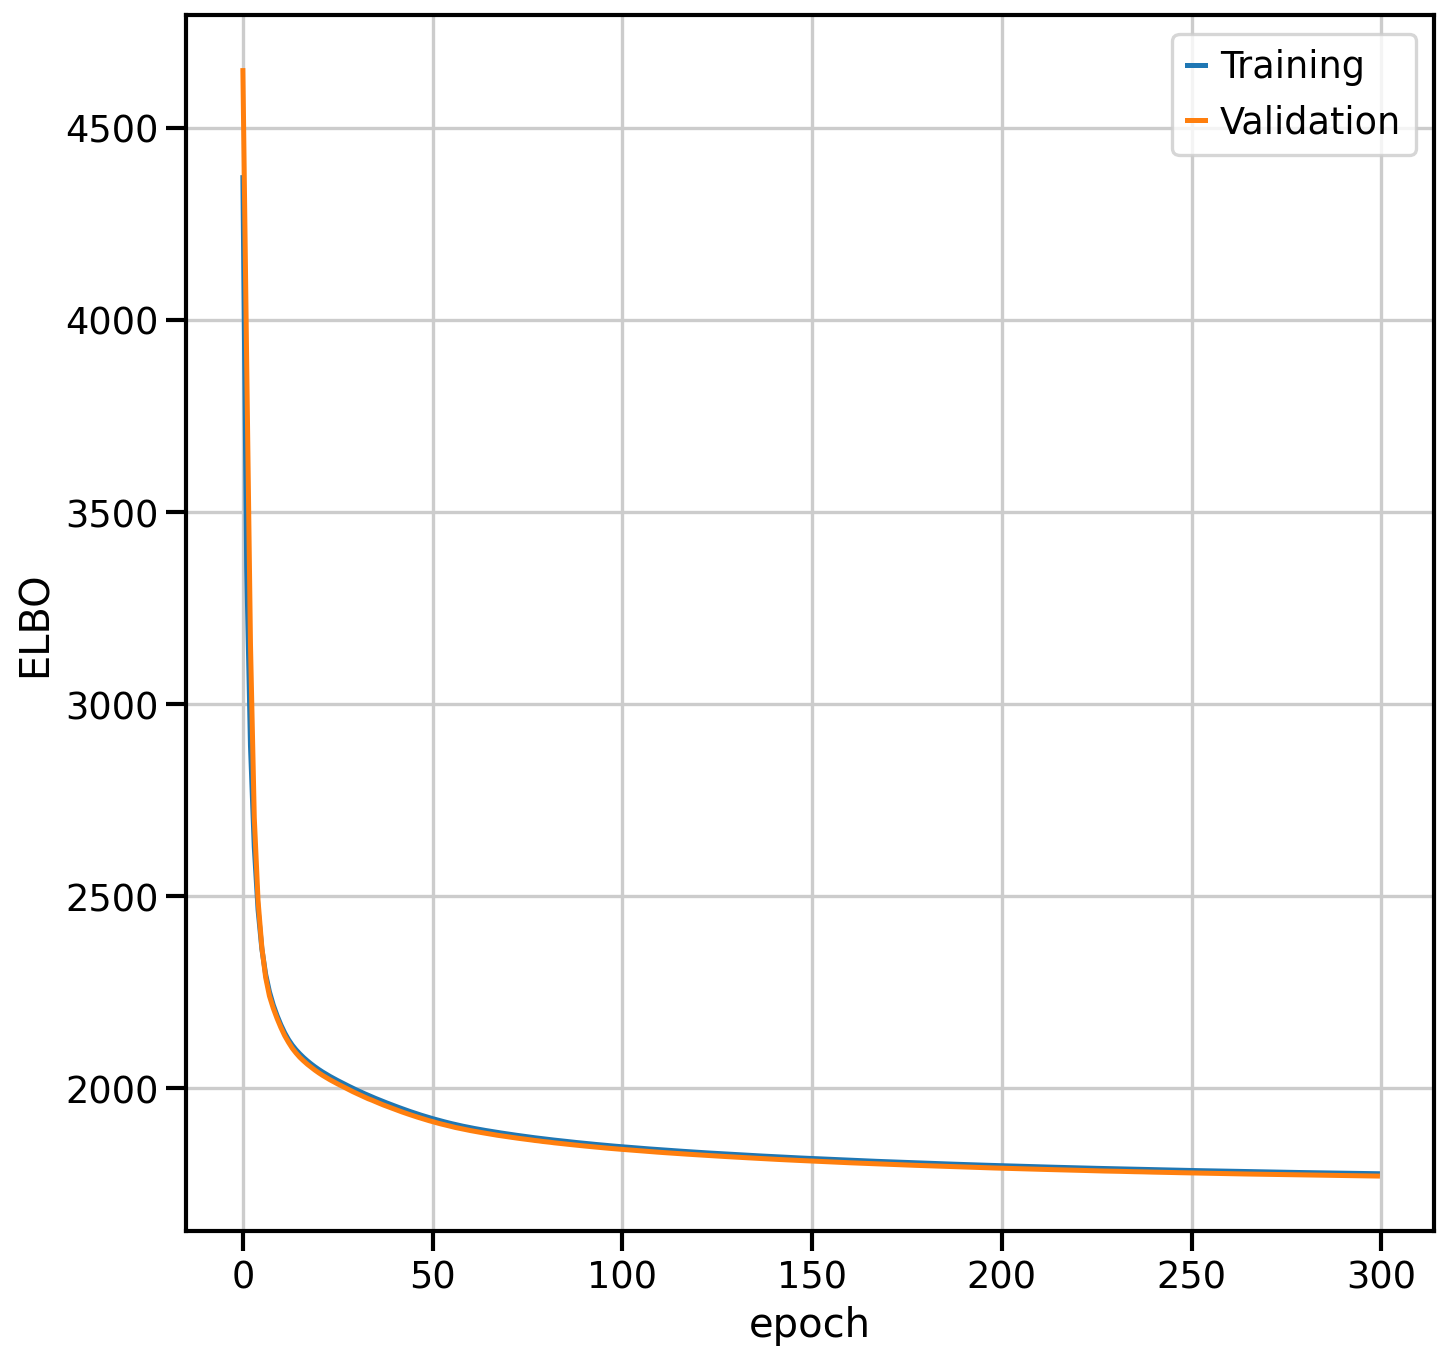

In [21]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
plt.plot(vae.history["elbo_train"], label="Training");
plt.plot(vae.history["elbo_validation"], label="Validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("ELBO");

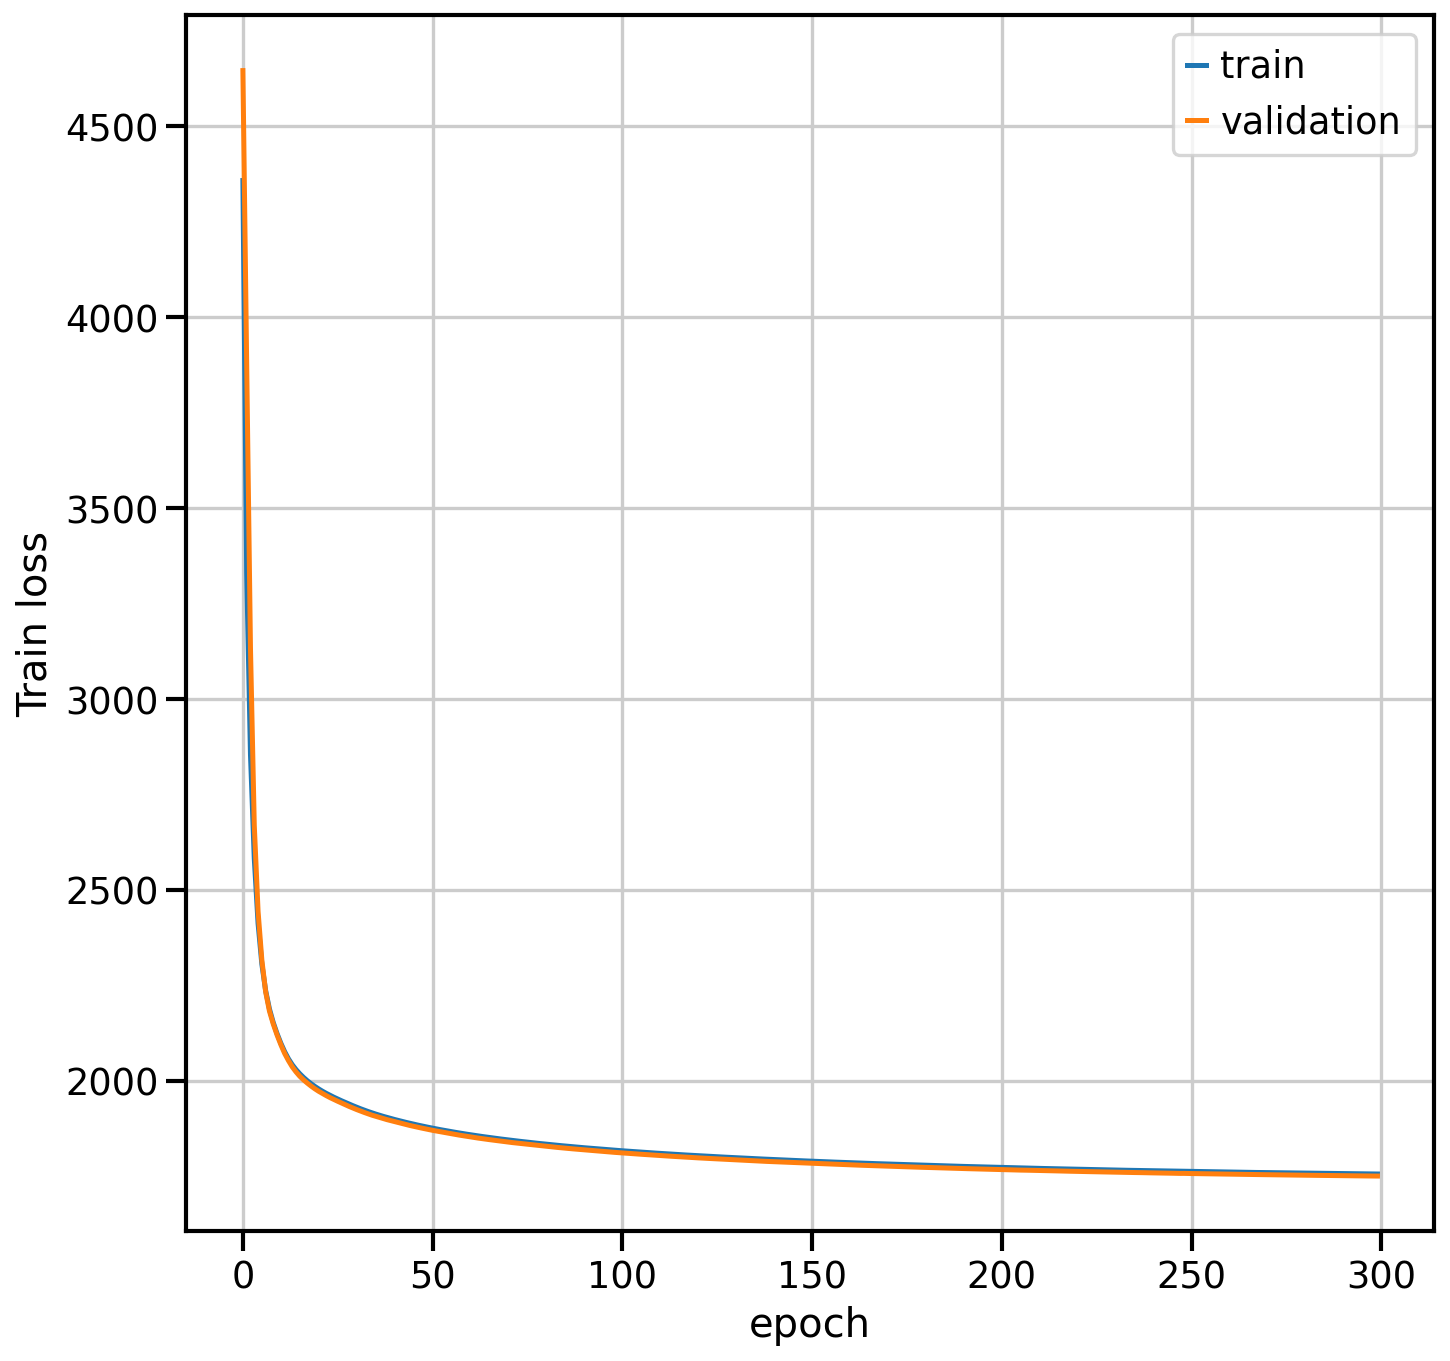

In [22]:
sns.set_context("talk")
plt.plot(vae.history["reconstruction_loss_train"], label="train");
plt.plot(vae.history["reconstruction_loss_validation"], label="validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("Train loss");

In [23]:
## loss per gene
elbo_loss_per_gene = vae.history['elbo_validation'].min()[0] / adata_train.n_vars
reconstruction_loss_per_gene = vae.history['reconstruction_loss_validation'].min()[0] / adata_train.n_vars

In [24]:
print("elbo loss per gene is {loss}".format(loss=elbo_loss_per_gene))
print("reconstruction loss per gene is {loss}".format(loss=reconstruction_loss_per_gene))

elbo loss per gene is 0.17708033447265625
reconstruction loss per gene is 0.17504456787109374


In [25]:
loaded_timepoint=20240813
hvg_flavor  = "seurat_v3_paper"

In [26]:
## Save latent embedding
x_scVI = vae.get_latent_representation()
outname = "SCAID.All.{t}.scVI_latent.HVG_{f}.npy".format(t=loaded_timepoint, f=hvg_flavor)
np.save(data_dir + outname, x_scVI)

In [27]:
## Save scVI Normalized Expression
scvi_normalized = vae.get_normalized_expression(library_size=10e4)
outname = "SCAID.All.{t}.scVI_normalized.HVG_{f}.npy".format(t=loaded_timepoint, f=hvg_flavor)
np.save(data_dir + outname, scvi_normalized)

In [ ]:
vae.view_anndata_setup()

## 06) Explore Output

In [29]:
adata = sc.read_h5ad('{d}SCAID.All.merged.h5ad'.format(d=data_dir))
adata.var_names_make_unique()

In [30]:
adata = adata[~adata.obs.Sample_ID.isna()].copy()

In [31]:
### UMAP config ###
n_neighbors=15
min_dist=0.3

### Takes about an hour

In [32]:
%%time
## Compute UMAP and Cluster using the Trained Data
emb_file = data_dir + "SCAID.All.{t}.scVI_latent.HVG_{f}.npy".format(t=loaded_timepoint, f=hvg_flavor)
X_scVI_emb = np.load(emb_file)
adata.obsm["X_scVI"] = X_scVI_emb
adata_train.obsm["X_scVI"] = X_scVI_emb

## Compute UMAP and Cluster using the Trained Data
norm_file = data_dir + "SCAID.All.{t}.scVI_normalized.HVG_{f}.npy".format(t=loaded_timepoint, f=hvg_flavor)
X_scVI_norm = np.load(norm_file)
adata.obsm["scvi_normalized"] = X_scVI_norm
adata_train.layers["scvi_normalized"] = X_scVI_norm

print("Computing KNN graph...")
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = n_neighbors, key_added="scvi", random_state = 42)

## UMAP
print("Computing UMAP...")
sc.tl.umap(adata, min_dist = min_dist, spread = 1.0, alpha = 1.0, gamma = 1.0, neighbors_key="scvi", random_state = 42)
adata.obsm["X_scvi_umap"]=adata.obsm["X_umap"]

Computing KNN graph...
computing neighbors
    finished: added to `.uns['scvi']`
    `.obsp['scvi_distances']`, distances for each pair of neighbors
    `.obsp['scvi_connectivities']`, weighted adjacency matrix (0:11:01)
Computing UMAP...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:43:18)
CPU times: user 13h 33min 33s, sys: 14min 56s, total: 13h 48min 30s
Wall time: 55min 6s


# 02. Saving Model and AnnData

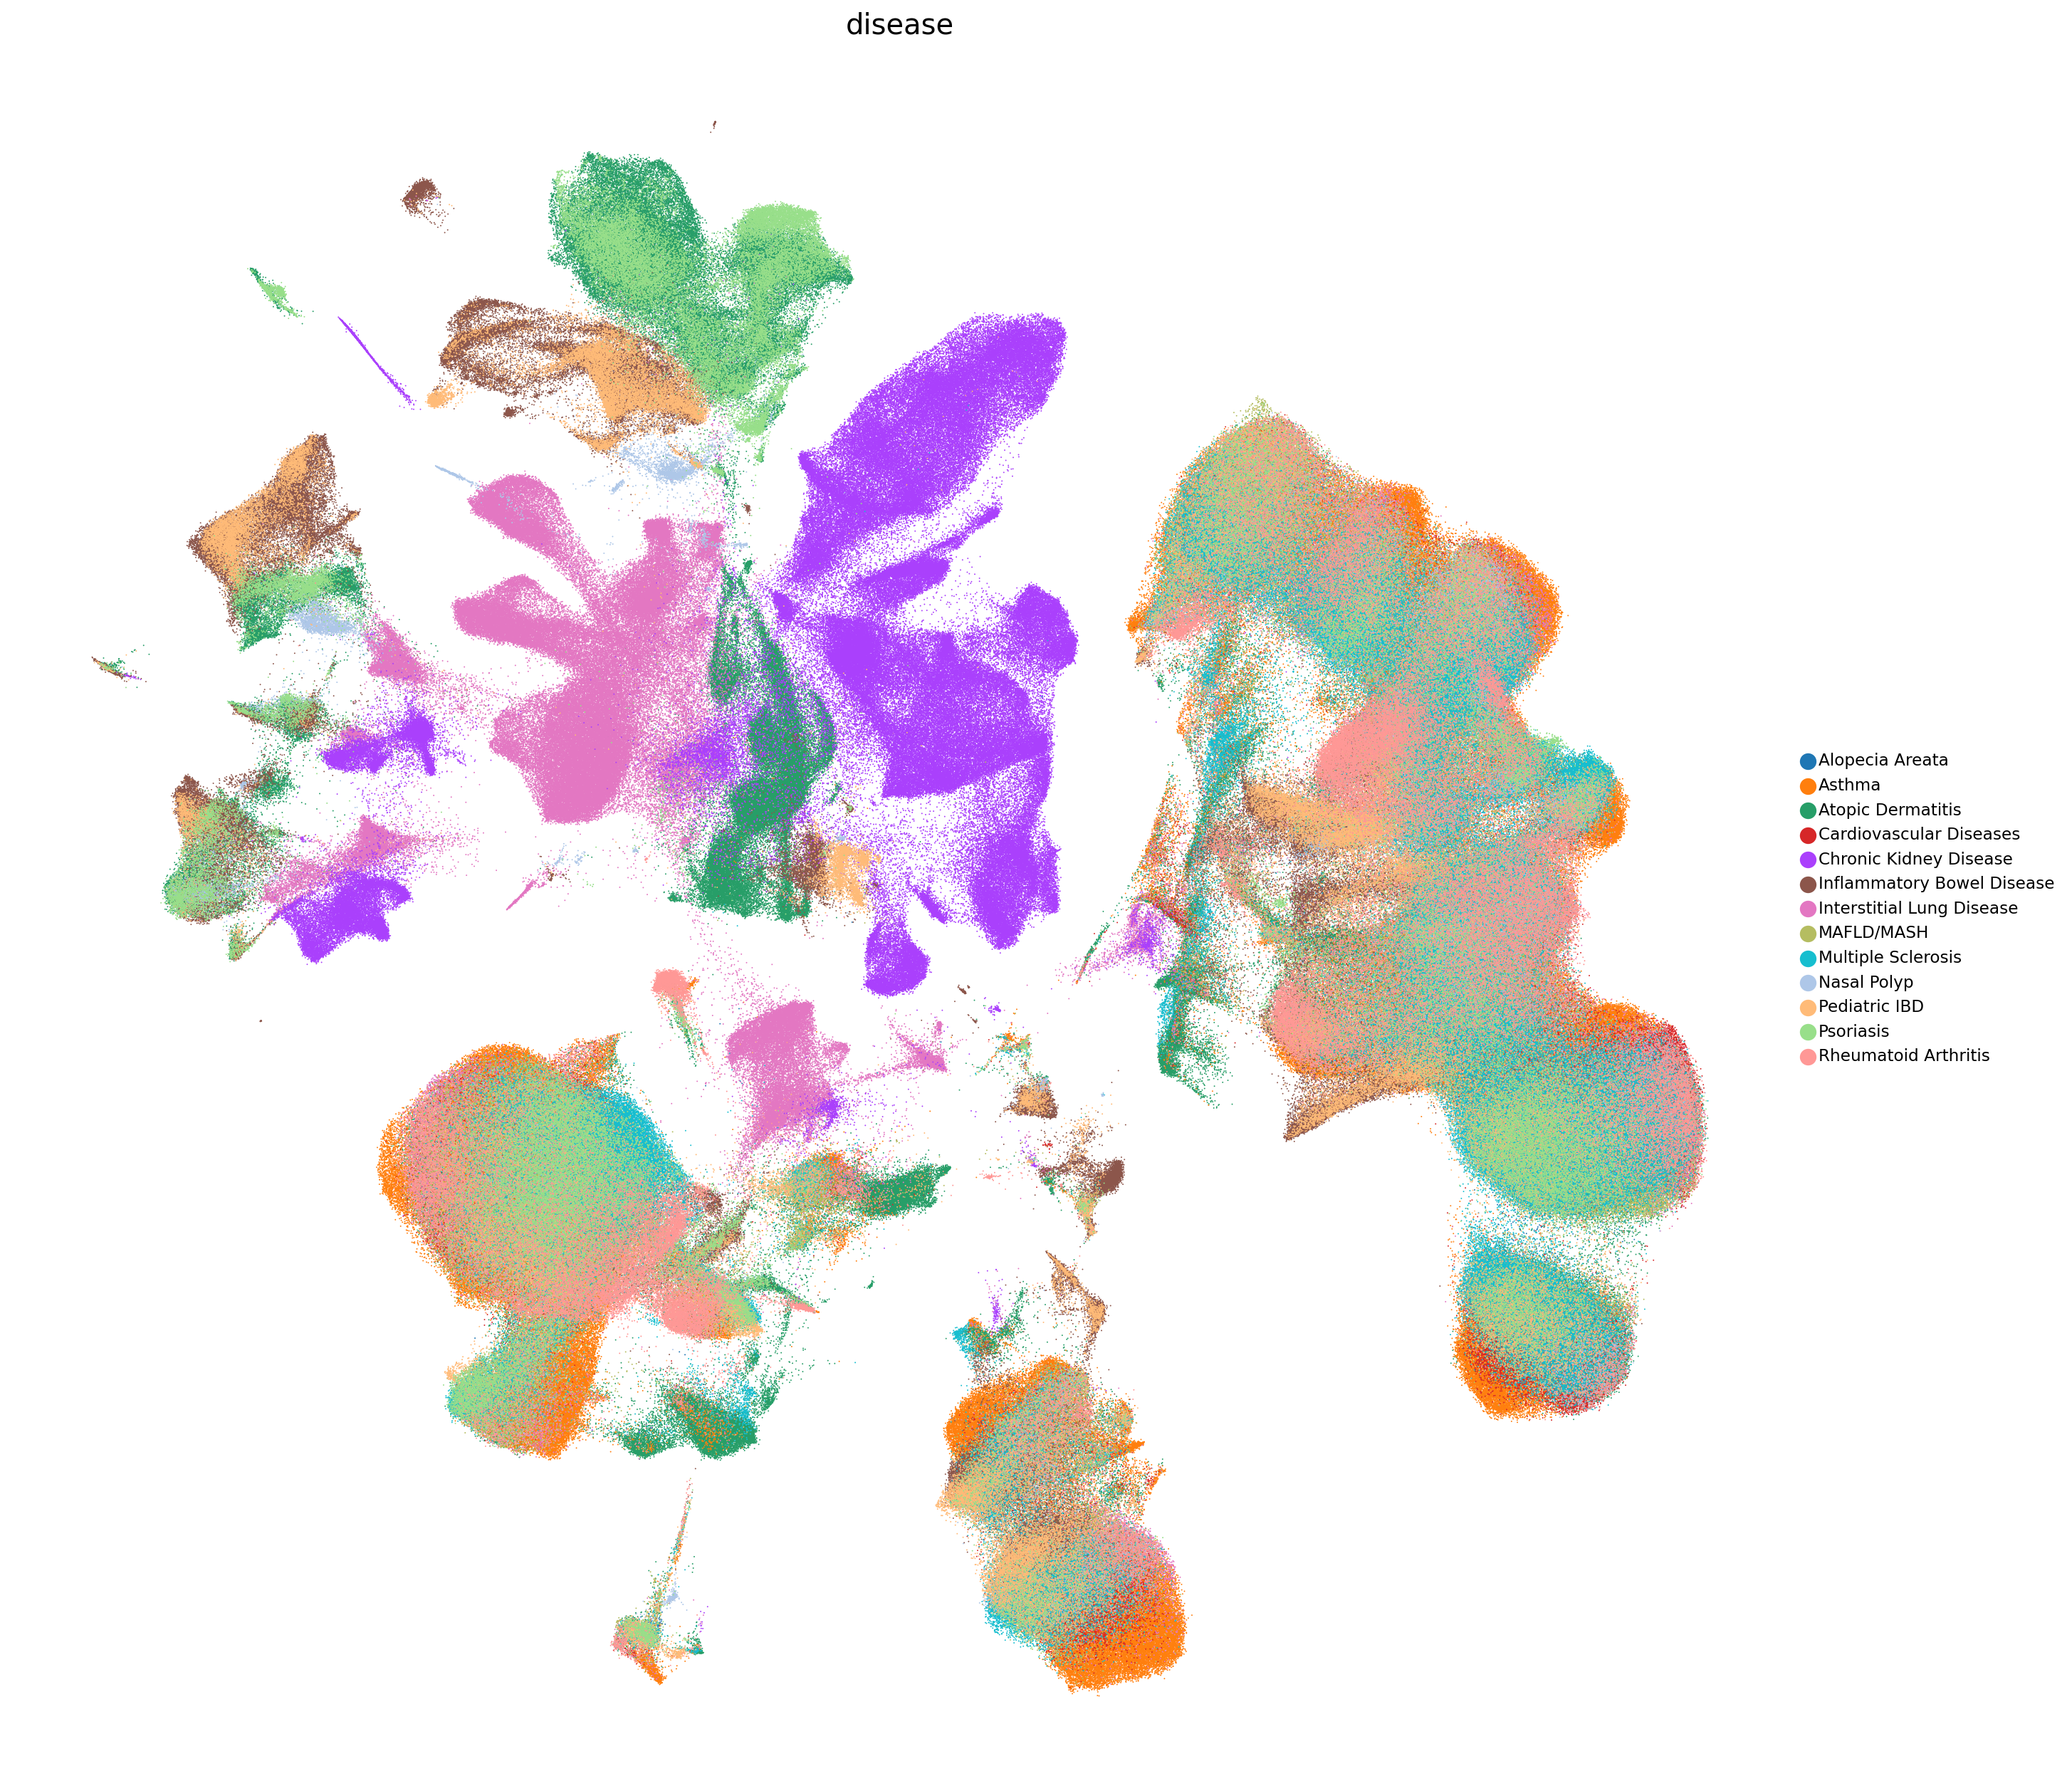

In [33]:
plt.rcParams["figure.figsize"] = [20,20]
warnings.filterwarnings("ignore")
sc.pl.umap(adata, 
           color=["disease"],
           size = 3,
           ncols = 1,
           #legend_loc = 'on data',
           legend_fontsize = 'xx-small',
           #add_outline=True,
           legend_fontoutline=3,
           frameon=False
          )

In [35]:
### Use normalize_total instead of normalize_per_cell Don't want to filter based on n_count
### target_sum=1e4 Getting CP10K
print("CP10K then Log-normalizing...")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["CP10K"]=adata.X.copy()

CP10K then Log-normalizing...
normalizing counts per cell
    finished (0:00:35)


In [ ]:
plt.rcParams["figure.figsize"] = [15,15]

plot_cols = adata.obs.columns[adata.obs.columns.str.startswith('CT') & adata.obs.columns.str.endswith('majority_voting')].tolist()

print(f"Number of cells {adata.n_obs}")

sc.pl.umap(adata, 
           color=plot_cols,
           size = 3,
           add_outline = True,
           ncols = 3,
           legend_loc = 'on data',
           legend_fontsize = 8,
           legend_fontoutline = 3,
           sort_order = True,
           frameon = False
          )

In [38]:
## Save Anndata
adata.write_h5ad("{d}SCAID.All.scVI.HVG_{f}.{t}.h5ad".format(d=data_dir, f=hvg_flavor, t=timestamp()))

In [39]:
## Save Model
vae.save("{d}models/SCAID.All.vae.HVG_{f}.{t}".format(d=data_dir, f=hvg_flavor, t=timestamp()), overwrite=True, save_anndata=True)

In [ ]:
ut.cluster_small_multiples_emb(adata, "disease", "X_umap")

In [ ]:
ut.cluster_small_multiples_emb(adata, "Suspension_Type", "X_umap")

In [ ]:
## Save Anndata
adata.write_h5ad("{d}SCAID.All.scVI.HVG_{f}.{t}.h5ad".format(d=data_dir, f=hvg_flavor, t=timestamp()))

# Leiden Clustering 5 ~ 6 hours

In [ ]:
## Clustering 
print("Clustering...")
sc.tl.leiden(adata, resolution=1.0, key_added='leiden_100', neighbors_key="scvi")
sc.tl.leiden(adata, resolution=2.0, key_added='leiden_200', neighbors_key="scvi")
sc.tl.leiden(adata, resolution=3.0, key_added='leiden_300', neighbors_key="scvi")

In [ ]:
# Assuming 'adata' is your AnnData object
adata.obs['Suspension_Type'].fillna('Cell', inplace=True)

In [ ]:
## Save Anndata
adata.write_h5ad("{d}SCAID.All.scVI.HVG_{f}.{t}.h5ad".format(d=data_dir, f=hvg_flavor, t=timestamp()))

In [ ]:
plt.rcParams["figure.figsize"] = [20,20]
warnings.filterwarnings("ignore")
sc.pl.umap(adata, 
           color=["background_fraction"],
           size = 3,
           ncols = 1,
           #legend_loc = 'on data',
           legend_fontsize = 'xx-small',
           #add_outline=True,
           legend_fontoutline=3,
           frameon=False
          )